In [1]:
from numpy import zeros, ones
from numpy.random import randn, randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout

In [2]:
(trainX, trainy), (testX, testy) = load_data()

170498071/170498071 [==============================] - 112s 1us/step


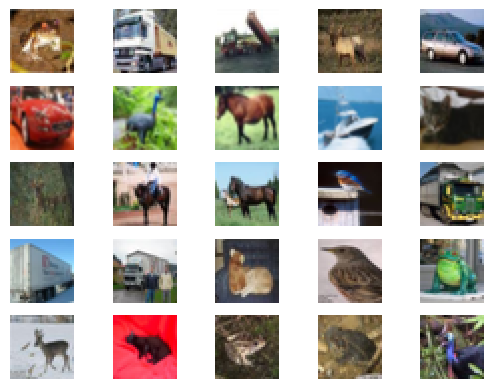

In [4]:
from matplotlib import pyplot as plt
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

In [5]:
def discriminator(in_shape=(32,32,3)):
	model = Sequential()
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Flatten()) #shape of 8192
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [7]:
test_discr = discriminator()
print(test_discr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
def generator(latent_dim):
	model = Sequential()
	n_nodes = 128 * 8 * 8 
	model.add(Dense(n_nodes, input_dim=latent_dim)) 
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) 
	return model 

In [11]:
test_gen = generator(100)
print(test_gen.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

In [12]:
def define_gan(generator, discriminator):
	discriminator.trainable = False  
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(l oss='binary_crossentropy', optimizer=opt)
	return model

In [13]:
def load_real_samples():
	(trainX, _), (_, _) = load_data()
	X = trainX.astype('float32')
	X = (X - 127.5) / 127.5  
	return X

In [14]:
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1)) 
	return X, y

In [15]:
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [16]:
def generate_fake_samples(generator, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = generator.predict(x_input)
	y = zeros((n_samples, 1)) 
	return X, y

In [17]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)  
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	g_model.save('cifar_generator_2epochs.h5')


In [19]:
latent_dim = 100
discriminator = discriminator()
generator = generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=2)

2/2 [==============================] - 0s 83ms/step
Epoch>1, Batch 1/390, d1=0.703, d2=0.694 g=0.693
2/2 [==============================] - 0s 82ms/step
Epoch>1, Batch 2/390, d1=0.649, d2=0.702 g=0.685
2/2 [==============================] - 0s 73ms/step
Epoch>1, Batch 3/390, d1=0.602, d2=0.713 g=0.675
2/2 [==============================] - 0s 75ms/step
Epoch>1, Batch 4/390, d1=0.556, d2=0.727 g=0.664
2/2 [==============================] - 0s 74ms/step
Epoch>1, Batch 5/390, d1=0.504, d2=0.745 g=0.653
2/2 [==============================] - 0s 85ms/step
Epoch>1, Batch 6/390, d1=0.458, d2=0.763 g=0.646
2/2 [==============================] - 0s 76ms/step
Epoch>1, Batch 7/390, d1=0.419, d2=0.769 g=0.652
2/2 [==============================] - 0s 77ms/step
Epoch>1, Batch 8/390, d1=0.379, d2=0.766 g=0.669
2/2 [==============================] - 0s 78ms/step
Epoch>1, Batch 9/390, d1=0.340, d2=0.742 g=0.701
2/2 [==============================] - 0s 79ms/step
Epoch>1, Batch 10/390, d1=0.277, d2=0.7

2/2 [==============================] - 0s 91ms/step
Epoch>1, Batch 161/390, d1=0.083, d2=1.038 g=0.613
2/2 [==============================] - 0s 87ms/step
Epoch>1, Batch 162/390, d1=0.090, d2=2.116 g=0.370
2/2 [==============================] - 0s 84ms/step
Epoch>1, Batch 163/390, d1=0.079, d2=2.634 g=0.382
2/2 [==============================] - 0s 85ms/step
Epoch>1, Batch 164/390, d1=0.103, d2=1.893 g=0.658
2/2 [==============================] - 0s 84ms/step
Epoch>1, Batch 165/390, d1=0.142, d2=0.921 g=1.465
2/2 [==============================] - 0s 82ms/step
Epoch>1, Batch 166/390, d1=0.263, d2=0.254 g=2.540
2/2 [==============================] - 0s 84ms/step
Epoch>1, Batch 167/390, d1=0.254, d2=0.108 g=2.994
2/2 [==============================] - 0s 84ms/step
Epoch>1, Batch 168/390, d1=0.309, d2=0.128 g=2.616
2/2 [==============================] - 0s 83ms/step
Epoch>1, Batch 169/390, d1=0.339, d2=0.159 g=2.398
2/2 [==============================] - 0s 87ms/step
Epoch>1, Batch 170/39

Epoch>1, Batch 240/390, d1=0.425, d2=0.340 g=2.315
2/2 [==============================] - 0s 82ms/step
Epoch>1, Batch 241/390, d1=0.466, d2=0.231 g=2.350
2/2 [==============================] - 0s 85ms/step
Epoch>1, Batch 242/390, d1=0.460, d2=0.213 g=2.409
2/2 [==============================] - 0s 86ms/step
Epoch>1, Batch 243/390, d1=0.389, d2=0.274 g=2.336
2/2 [==============================] - 0s 93ms/step
Epoch>1, Batch 244/390, d1=0.325, d2=0.463 g=2.332
2/2 [==============================] - 0s 88ms/step
Epoch>1, Batch 245/390, d1=0.471, d2=0.575 g=2.228
2/2 [==============================] - 0s 89ms/step
Epoch>1, Batch 246/390, d1=0.291, d2=0.556 g=2.944
2/2 [==============================] - 0s 87ms/step
Epoch>1, Batch 247/390, d1=0.486, d2=0.139 g=3.455
2/2 [==============================] - 0s 95ms/step
Epoch>1, Batch 248/390, d1=0.724, d2=0.229 g=2.913
2/2 [==============================] - 0s 85ms/step
Epoch>1, Batch 249/390, d1=0.588, d2=0.175 g=2.553
2/2 [=================

2/2 [==============================] - 0s 87ms/step
Epoch>1, Batch 320/390, d1=0.639, d2=0.592 g=1.083
2/2 [==============================] - 0s 109ms/step
Epoch>1, Batch 321/390, d1=0.498, d2=0.629 g=1.049
2/2 [==============================] - 0s 100ms/step
Epoch>1, Batch 322/390, d1=0.517, d2=0.528 g=1.065
2/2 [==============================] - 0s 115ms/step
Epoch>1, Batch 323/390, d1=0.532, d2=0.599 g=1.003
2/2 [==============================] - 0s 103ms/step
Epoch>1, Batch 324/390, d1=0.532, d2=0.665 g=0.995
2/2 [==============================] - 0s 82ms/step
Epoch>1, Batch 325/390, d1=0.557, d2=0.615 g=0.991
2/2 [==============================] - 0s 97ms/step
Epoch>1, Batch 326/390, d1=0.599, d2=0.660 g=0.933
2/2 [==============================] - 0s 110ms/step
Epoch>1, Batch 327/390, d1=0.575, d2=0.682 g=0.841
2/2 [==============================] - 0s 95ms/step
Epoch>1, Batch 328/390, d1=0.550, d2=0.746 g=0.751
2/2 [==============================] - 0s 92ms/step
Epoch>1, Batch 3

Epoch>2, Batch 9/390, d1=0.648, d2=0.427 g=1.291
2/2 [==============================] - 0s 90ms/step
Epoch>2, Batch 10/390, d1=0.560, d2=0.446 g=1.351
2/2 [==============================] - 0s 91ms/step
Epoch>2, Batch 11/390, d1=0.545, d2=0.328 g=1.426
2/2 [==============================] - 0s 88ms/step
Epoch>2, Batch 12/390, d1=0.505, d2=0.402 g=1.344
2/2 [==============================] - 0s 87ms/step
Epoch>2, Batch 13/390, d1=0.441, d2=0.418 g=1.319
2/2 [==============================] - 0s 86ms/step
Epoch>2, Batch 14/390, d1=0.478, d2=0.471 g=1.151
2/2 [==============================] - 0s 85ms/step
Epoch>2, Batch 15/390, d1=0.404, d2=0.523 g=1.079
2/2 [==============================] - 0s 100ms/step
Epoch>2, Batch 16/390, d1=0.418, d2=0.558 g=0.969
2/2 [==============================] - 0s 109ms/step
Epoch>2, Batch 17/390, d1=0.405, d2=0.649 g=0.851
2/2 [==============================] - 0s 85ms/step
Epoch>2, Batch 18/390, d1=0.408, d2=0.749 g=0.825
2/2 [==========================

2/2 [==============================] - 0s 87ms/step
Epoch>2, Batch 168/390, d1=0.637, d2=0.565 g=0.975
2/2 [==============================] - 0s 86ms/step
Epoch>2, Batch 169/390, d1=0.590, d2=0.551 g=0.880
2/2 [==============================] - 0s 88ms/step
Epoch>2, Batch 170/390, d1=0.585, d2=0.603 g=0.816
2/2 [==============================] - 0s 91ms/step
Epoch>2, Batch 171/390, d1=0.609, d2=0.668 g=0.819
2/2 [==============================] - 0s 91ms/step
Epoch>2, Batch 172/390, d1=0.597, d2=0.733 g=0.737
2/2 [==============================] - 0s 87ms/step
Epoch>2, Batch 173/390, d1=0.609, d2=0.745 g=0.691
2/2 [==============================] - 0s 90ms/step
Epoch>2, Batch 174/390, d1=0.648, d2=0.794 g=0.702
2/2 [==============================] - 0s 94ms/step
Epoch>2, Batch 175/390, d1=0.622, d2=0.864 g=0.665
2/2 [==============================] - 0s 85ms/step
Epoch>2, Batch 176/390, d1=0.628, d2=0.884 g=0.662
2/2 [==============================] - 0s 87ms/step
Epoch>2, Batch 177/39

Epoch>2, Batch 247/390, d1=0.603, d2=0.733 g=0.689
2/2 [==============================] - 0s 88ms/step
Epoch>2, Batch 248/390, d1=0.503, d2=0.787 g=0.726
2/2 [==============================] - 0s 84ms/step
Epoch>2, Batch 249/390, d1=0.571, d2=0.727 g=0.735
2/2 [==============================] - 0s 94ms/step
Epoch>2, Batch 250/390, d1=0.545, d2=0.719 g=0.737
2/2 [==============================] - 0s 87ms/step
Epoch>2, Batch 251/390, d1=0.590, d2=0.718 g=0.762
2/2 [==============================] - 0s 86ms/step
Epoch>2, Batch 252/390, d1=0.622, d2=0.682 g=0.786
2/2 [==============================] - 0s 88ms/step
Epoch>2, Batch 253/390, d1=0.605, d2=0.674 g=0.808
2/2 [==============================] - 0s 88ms/step
Epoch>2, Batch 254/390, d1=0.591, d2=0.661 g=0.807
2/2 [==============================] - 0s 88ms/step
Epoch>2, Batch 255/390, d1=0.602, d2=0.667 g=0.809
2/2 [==============================] - 0s 89ms/step
Epoch>2, Batch 256/390, d1=0.573, d2=0.661 g=0.803
2/2 [=================

In [20]:
from keras.models import load_model
from numpy.random import randn

In [21]:
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

1/1 [==============================] - 0s 131ms/step


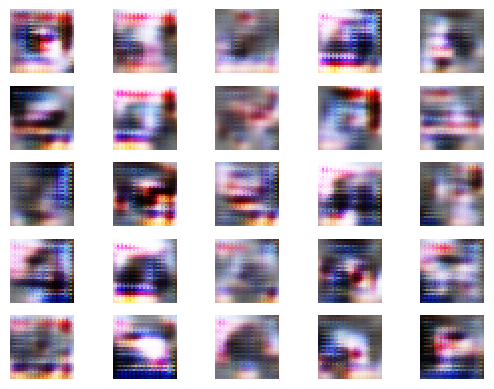

In [29]:
import keras
model = load_model('cifar_generator_2epochs.h5') 
optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.save('cifar_generator_2epochs.h5')
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

show_plot(X, 5)